## 1- introduction
* image registration: process of **transforming images into a common coordinate system** so **corresponding pixels represent homologous biological points**
* **Elastix**: open source **command-line program** for **intensity-based registration** of medical images, allows quickly configure, test and compare different registration methods
* **SimpleElastix**: an **extension of SimpleITK**, allows configuring and **running Elastix entirely in Python** and some other languages
* with SimpleElastix it's made easier and more memory and disk I/O efficient than Elastix

* image registration involves two images: fixed and moving
* transform: the spatial mapping of points from the fixed to points in moving (correspondence establishment)
* similarity metric: measure of how well fixed and moving image match
* optimizer: optimizes similarity metric over search space
* serach space: parameters of transform


* optimizer adjusts the parameters of transform in a way that minimizes the difference between the two images in terms of similarity metric
* so we just need to specify the metric we want to optimize
* when we want smooth deformations, we use regularization to penalize sharp transformation
* when we start with a high level of smoothing, and gradually sharpen the image, we use a multi-resolution approach

### registration components
#### image pyramids
* a multi-resolution pyramid strategy improves the capture range and robustness of registration
* three types of pyramid: SmoothingImagePyramid, RecursiveImagePyramid, ShrinkingImagePyramid
* **SmoothingImagePyramid** smoothes the image with Gaussian kernel at different scales
* **RecursiveImagePyramid** smoothes and downsamples the image
* **ShrinkingImagePyramid** merely downsamples the image


* parameters to set for multi-resolution strategy: **NumberOfResolutions** (in general 3 resolutions will be sufficient. if fixed and moving images are far away we migh want to increase it to 5 or 6, this way pays more attention to register large, dominant structures in the beginning) and **ImagePyramidSchedule**(defines amount of blurring and downsampling in each direction and for each resolution level) (if data is highly anisotropic, you might want to blur less in the direction of largest spacing).

example:
<br>(NumberOfResolutions 4)
<br>(FixedImagePyramidSchedule 8 8 8 4 4 4 2 2 2 1 1 1)

means that at resolution level 1, voxels are blurred with 4/2 voxels in each direction. (sigma is half pyramid schedule value)

#### masks
* if more interested in aligning substructures than glonal anatomy
* if you need an irregular region of interest (ROI), you can use masks
* when to use masks:
  * image contains artificial edges with no real meaning. the registration tries to align those and neglect the meaningful edges
  * image contains structures in the neighborhood of your ROI that may influence the registration within ROI
* only a fixed image mask is sufficient to focus the registrtion on the ROI, you only want to use mask for moving image, when the moving image contains highly perturbed grey levels near the ROI
* if using multi-resolution registration, set (ErodeMask "true"), since you do not want information from the artificial edge to flow into your ROI during smoothing step, (if the edges around the ROI are meaningful, set it to false), becuase edge will help to guide the registration

#### transforms
* constrains the solution space to that type of deformation (example: intra-subject applications: may be sufficient to consider only rigid transformation) (example2: a cross-sectional study demands more flexible transformation models to allow normal anatomical variabilities between patients)
* number of parameters correspond to the degree of freedom (DOF)
* DOF is equal to the dimensionality of the search space
* often good idea to start simple transforms and gradually increase complexity
* some common transforms: 
  * translation
  * rigid (rotation, translation)
  * Euler (rotaiton, translation)
  * affine (rotation, translation, scaling, shearing)
  * bspline (non-rigid)
  * Spline-Kernel transform (non-rigid)
  * weighted combination of any of these
* transform is from fixed image to moving image. this allows us to iterate over the fixed image and pick a pixel from the moving image for every pixel in the fixed image

#### metric
* similarity metric: measures degree of similarity between moving and fixed
* metric samples intensity values from fixed and transformed moving and evaluates the fitness value and derivatives (to pass to optimizer)
* some metrics can not handle inter-modality comparisons. some metrics have large capture range while others require initialization close to the optimil position
* you might require trial and error to find the best metric for a given problem
* **Mean Squared Difference (SSD)** pixel-wise intensity differences between two images squared mean. (good for the images with the same intensity distribution, like the same modality)
* **Normalized Correlation Coefficient (NCC)** pixel-wise cross-correlation normalized by the square root of the autocorrelation of the images. it's invariant to linear differences between intensity distributions. well for intra-modal CT registration.
* **Mutual Information (MI)** well-suited for multi-modal image pairs as well as mono-modal. sometimes better performance with normalized MI.
* **Mattes Mutual Information** samples te same pixels in every iteration.
* **Kappa Similarity Meric** measures the overlap of the segmented structures, specifically to register segmentations. (but usually better to conver a binary image to a distance map and apply one of the usual metrics.

#### optimizers
* estimates the optimal transform parameters in iterative fashion
* Gradient Deccent (GD), Robbins-Mobroe (RM), **Adaptive stochastic gradient descent(ASGD)**, conjugate gradient (CG), Quasi-Newton, simultaneous pertubation (SP)

#### samplers
* samples some points for the metric to evaluate only a subset of randomly sampled voxels
* using ImageSampler parameter (grid, random, random coordinate, full sampling)

#### interpolators
* is required to evaluate the image intensity at the mapped off-grid position
* NearestNeighborINterpolator: value of the spatially closest voxel. good for binary images
* LinearInterpolator: weighted average of surrounding voxels. (best time performance with this together with random coordinate sampler during optimization)
* BSplineInterpolatro: using b-spline approximations of user-defined order N. 1st order bspline correspond to linear interpolation. FinalBSplineInterpolatorFloat

#### images
* geometrical concepts associated with ITK images: ![Alt](images/se_001.JPG "Title")
* pixels represent the center of pixels

## 2- Hello World
* example ellustrating how to use SimpleElastix
* keeping it simple for now: a single function call we can specify fixed, moving image and type of registration. SimpleElatix then registers our images using sensible default parameters

### Registration With Translation Transform
consider these two brain MRIs.
![Alt](images/se_002.JPG "Title")
We identify objects are related by a simple spatial shift so a translation transform should suffice to align them (correct misalignment)

#### procedural interface
* short-hand notation (procedural or functional interface)
* less flexible than the object-oriented interface
* very simple to use

In [9]:
# a function to read dicom series from folders and returning the sitk image object

def sitkReadDicom(dicom_dir):
    
    print("Reading Dicom directory:", dicom_dir)
    reader = sitk.ImageSeriesReader()
    dicom_names = reader.GetGDCMSeriesFileNames(dicom_dir)
    reader.SetFileNames(dicom_names)
    image = reader.Execute()

    size = image.GetSize()
    print("Image size:", size[0], size[1], size[2])
    return image

In [6]:
# a function to write a dicom series
import SimpleITK as sitk
import os, sys


import time
def sitkWriteDicom(filtered_image, outputDir):
#     series_IDs = sitk.ImageSeriesReader.GetGDCMSeriesIDs(dicomDir)
#     if not series_IDs:
#         print("ERROR: given directory \""+data_directory+"\" does not contain a DICOM series.")
#         sys.exit(1)
#     series_file_names = sitk.ImageSeriesReader.GetGDCMSeriesFileNames(dicomDir, series_IDs[0])

#     series_reader = sitk.ImageSeriesReader()
#     series_reader.SetFileNames(series_file_names)

    # Configure the reader to load all of the DICOM tags (public+private):
    # By default tags are not loaded (saves time).
    # By default if tags are loaded, the private tags are not loaded.
    # We explicitly configure the reader to load tags, including the
    # private ones.
#     series_reader.MetaDataDictionaryArrayUpdateOn()
#     series_reader.LoadPrivateTagsOn()
#     image3D = series_reader.Execute()

    # Write the 3D image as a series
    # IMPORTANT: There are many DICOM tags that need to be updated when you modify an
    #            original image. This is a delicate opration and requires knowlege of
    #            the DICOM standard. This example only modifies some. For a more complete
    #            list of tags that need to be modified see:
    #                           http://gdcm.sourceforge.net/wiki/index.php/Writing_DICOM

    writer = sitk.ImageFileWriter()
    # Use the study/series/frame of reference information given in the meta-data
    # dictionary and not the automatically generated information from the file IO
    writer.KeepOriginalImageUIDOn()

    # Copy relevant tags from the original meta-data dictionary (private tags are also
    # accessible).
#     tags_to_copy = ["0010|0010", # Patient Name
#                     "0010|0020", # Patient ID
#                     "0010|0030", # Patient Birth Date
#                     "0020|000D", # Study Instance UID, for machine consumption
#                     "0020|0010", # Study ID, for human consumption
#                     "0008|0020", # Study Date
#                     "0008|0030", # Study Time
#                     "0008|0050", # Accession Number
#                     "0008|0060"  # Modality
#     ]

    modification_time = time.strftime("%H%M%S")
    modification_date = time.strftime("%Y%m%d")

    # Copy some of the tags and add the relevant tags indicating the change.
    # For the series instance UID (0020|000e), each of the components is a number, cannot start
    # with zero, and separated by a '.' We create a unique series ID using the date and time.
    # tags of interest:
    direction = filtered_image.GetDirection()
#[(k, series_reader.GetMetaData(0,k)) for k in tags_to_copy if series_reader.HasMetaDataKey(0,k)] + \
    series_tag_values = [("0008|0031",modification_time), # Series Time
                      ("0008|0021",modification_date), # Series Date
                      ("0008|0008","DERIVED\\SECONDARY"), # Image Type
                      ("0020|000e", "1.2.826.0.1.3680043.2.1125."+modification_date+".1"+modification_time), # Series Instance UID
                      ("0020|0037", '\\'.join(map(str, (direction[0], direction[3], direction[6],# Image Orientation (Patient)
                                                        direction[1],direction[4],direction[7]))))]#,
                      #("0008|103e", series_reader.GetMetaData(0,"0008|103e") + " Processed-SimpleITK") # Series Description

    for i in range(filtered_image.GetDepth()):
        image_slice = filtered_image[:,:,i]
        # Tags shared by the series.
        for tag, value in series_tag_values:
            image_slice.SetMetaData(tag, value)
        # Slice specific tags.
        image_slice.SetMetaData("0008|0012", time.strftime("%Y%m%d")) # Instance Creation Date
        image_slice.SetMetaData("0008|0013", time.strftime("%H%M%S")) # Instance Creation Time
        image_slice.SetMetaData("0020|0032", '\\'.join(map(str,filtered_image.TransformIndexToPhysicalPoint((0,0,i))))) # Image Position (Patient)
        image_slice.SetMetaData("0020,0013", str(i)) # Instance Number

        # Write to the output directory and add the extension dcm, to force writing in DICOM format.
        writer.SetFileName(os.path.join(sys.argv[2],str(i)+'.dcm'))
        writer.Execute(image_slice)
        print(f"writing slice {i}")
    print("writing image done")

In [44]:
def sitkWrite(image3D, data_directory="D:\\0-image_orig", output_directory="D:\\1-image_copy"):
    # Read the original series. First obtain the series file names using the
    # image series reader.
    series_IDs = sitk.ImageSeriesReader.GetGDCMSeriesIDs(data_directory)
    if not series_IDs:
        print("ERROR: given directory \"" + data_directory +
              "\" does not contain a DICOM series.")
        sys.exit(1)
    series_file_names = sitk.ImageSeriesReader.GetGDCMSeriesFileNames(
        data_directory, series_IDs[0])

    series_reader = sitk.ImageSeriesReader()
    series_reader.SetFileNames(series_file_names)

    # Configure the reader to load all of the DICOM tags (public+private):
    # By default tags are not loaded (saves time).
    # By default if tags are loaded, the private tags are not loaded.
    # We explicitly configure the reader to load tags, including the
    # private ones.
    series_reader.MetaDataDictionaryArrayUpdateOn()
    series_reader.LoadPrivateTagsOn()
    series_reader.Execute()

    # Modify the image (blurring)
    filtered_image = image3D

    # Write the 3D image as a series
    # IMPORTANT: There are many DICOM tags that need to be updated when you modify
    #            an original image. This is a delicate opration and requires
    #            knowledge of the DICOM standard. This example only modifies some.
    #            For a more complete list of tags that need to be modified see:
    #                http://gdcm.sourceforge.net/wiki/index.php/Writing_DICOM

    writer = sitk.ImageFileWriter()
    # Use the study/series/frame of reference information given in the meta-data
    # dictionary and not the automatically generated information from the file IO
    writer.KeepOriginalImageUIDOn()

    # Copy relevant tags from the original meta-data dictionary (private tags are
    # also accessible).
    tags_to_copy = ["0010|0010",  # Patient Name
                    "0010|0020",  # Patient ID
                    "0010|0030",  # Patient Birth Date
                    "0020|000D",  # Study Instance UID, for machine consumption
                    "0020|0010",  # Study ID, for human consumption
                    "0008|0020",  # Study Date
                    "0008|0030",  # Study Time
                    "0008|0050",  # Accession Number
                    "0008|0060"  # Modality
                    ]

    modification_time = time.strftime("%H%M%S")
    modification_date = time.strftime("%Y%m%d")

    # Copy some of the tags and add the relevant tags indicating the change.
    # For the series instance UID (0020|000e), each of the components is a number,
    # cannot start with zero, and separated by a '.' We create a unique series ID
    # using the date and time.
    # Tags of interest:
    direction = filtered_image.GetDirection()
    series_tag_values = [
                            (k, series_reader.GetMetaData(0, k))
                            for k in tags_to_copy
                            if series_reader.HasMetaDataKey(0, k)] + \
                        [("0008|0031", modification_time),  # Series Time
                         ("0008|0021", modification_date),  # Series Date
                         ("0008|0008", "DERIVED\\SECONDARY"),  # Image Type
                         ("0020|000e", "1.2.826.0.1.3680043.2.1125." +
                          modification_date + ".1" + modification_time),
                         # Series Instance UID
                         ("0020|0037",
                          '\\'.join(map(str, (direction[0], direction[3],
                                              direction[6],
                                              # Image Orientation (Patient)
                                              direction[1], direction[4],
                                              direction[7])))),
                         ("0008|103e",
                          series_reader.GetMetaData(0, "0008|103e")
                          + " Processed-SimpleITK")]  # Series Description

    castFilter = sitk.CastImageFilter()
    castFilter.SetOutputPixelType(sitk.sitkUInt16)

    # Convert floating type image (imgSmooth) to int type (imgFiltered)
    filtered_image2 = castFilter.Execute(filtered_image)

    for i in range(filtered_image2.GetDepth()):
        image_slice = filtered_image2[:, :, i]
        # Tags shared by the series.
        for tag, value in series_tag_values:
            image_slice.SetMetaData(tag, value)
        # Slice specific tags.
        #   Instance Creation Date
        image_slice.SetMetaData("0008|0012", time.strftime("%Y%m%d"))
        #   Instance Creation Time
        image_slice.SetMetaData("0008|0013", time.strftime("%H%M%S"))
        #   Image Position (Patient)
        image_slice.SetMetaData("0020|0032", '\\'.join(
            map(str, filtered_image2.TransformIndexToPhysicalPoint((0, 0, i)))))
        #   Instace Number
        image_slice.SetMetaData("0020|0013", str(i))
        image_slice.SetMetaData("0020|000e", "1.2.826.0.1.3680043.2.1125."+modification_date+".1"+modification_time)

        # Write to the output directory and add the extension dcm, to force writing
        # in DICOM format.
        writer.SetFileName(os.path.join(output_directory, str(i) + '.dcm'))
        writer.Execute(image_slice)

In [7]:
fixedImage = "D:\\TOFA\\images\MR\\01-019\\20190926\\left_pre"
movingImage = "D:\\TOFA\\images\\MR\\01-019\\20190926\\left_gd"

In [10]:
# procedural interface
import SimpleITK as sitk

resultImage = sitk.Elastix(sitkReadDicom(fixedImage), sitkReadDicom(movingImage), "translation")

Reading Dicom directory: D:\TOFA\images\MR\01-019\20190926\left_pre
Image size: 400 400 180
Reading Dicom directory: D:\TOFA\images\MR\01-019\20190926\left_gd
Image size: 400 400 180


In [14]:
import SimpleITK as sitk

# Object oritented interface
elastixImageFilter = sitk.ElastixImageFilter()
elastixImageFilter.SetFixedImage(sitkReadDicom(fixedImage))
elastixImageFilter.SetMovingImage(sitkReadDicom(movingImage))
resultImage = elastixImageFilter.Execute()

Reading Dicom directory: D:\TOFA\images\MR\01-019\20190926\left_pre
Image size: 400 400 180
Reading Dicom directory: D:\TOFA\images\MR\01-019\20190926\left_gd
Image size: 400 400 180


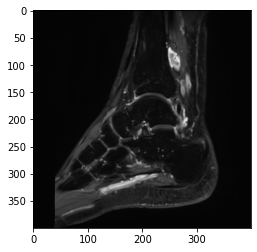

In [46]:
import matplotlib.pyplot as plt

nda = sitk.GetArrayFromImage(resultImage)[90, :, :]
plt.imshow(nda, cmap='gray')

In [45]:
sitkWrite(image3D=resultImage, data_directory=fixedImage)

#### object-oriented interface
* code is more flexible but less simple
  * for example the final deformation field can be retrieved
  (like warping other images with the same transformation)
  * image quality is reduced from resampling twice the resulting image
* suitable for more advanced use cases and scripting purposes
* more verbose, but a lot more powerful

In [ ]:
import SimpleITK as sitk

fixedImage = sitk.ReadImage('fixedImage.nii')
movingImage = sitk.ReadImage('movingImage.nii')
parameterMap = sitk.GetDefaultParameterMap('translation')

elastixImageFilter = sitk.ElastixImageFilter()
elastixImageFilter.SetFixedImage(fixedImage)
elastixImageFilter.SetMovingImage(movingImage)
elastixImageFilter.SetParameterMap(parameterMap)
elastixImageFilter.Execute()

resultImage = elastixImageFilter.GetResultImage()
transformParameterMap = elastixImageFilter.GetTransformParameterMap()

* we can now transform an entire population of images (e.g. binary label images for segmentation of different brain regions) using the same parameter map and a single instance of transformix

In [ ]:
transformixImageFilter = sitk.TransformixImageFilter()
transformixImageFilter.SetTransformParameterMap(transformParameterMap)

population = ['image1.hdr', 'image2.hdr', ..., 'imageN.hdr']

for filename in population:
    transformixImageFilter.SetMovingImage(sitk.ReadImage(filename))
    transformixImageFilter.Execute()
    sitk.WriteImage(transformixImageFilter.GetResultImage(), "result_"+filename)

* the object-oriented interface facilitates reuse of components and dramatically simplifies book-keeping and boilerplate code
* next section: closer look at the parameter map interface that configures the registration components

## 3- Parameter Maps
* chapter 2, we saw configure an entire multi-resolution registration with a single parameter
* examine how SimpleElastix configures registration components internally
* will help solve complex problems that require problem-specific tuning
* configure the registration procedure using the **concept of parameter map**
* parameter map: collection of key-value pairs, automatically defines the componenets of registration and settings they require
* elastix and transformix read text files in which parameters are specified according to the (key value) format
* in SimpleElastix we can also use data objects for parameter files:

In [ ]:
import SimpleElastix as sitk

p = sitk.ParameterMap()
p['Registration'] = ['MultiResolutionRegistration']
p['Transform'] = ['TranslationTransform']
...

### Default parameter maps


In [ ]:
# ElastixImageFilter will register our images with a 
# translation -> affine -> b-splie multi-resolution approach by default
# we simply leave out the call to SetParameterMap to achieve this

import SimpleITK as sitk

# Functional interface
resultImage = sitk.Elastix(sitk.ReadImage('fixedImage.nii'), sitk.ReadImage('movingImage.nii'))

# Object oritented interface
elastixImageFilter = sitk.ElastixImageFilter()
elastixImageFilter.SetFixedImage(sitk.ReadImage('fixedImage.nii'))
elastixImageFilter.SetMovingImage(sitk.ReadImage('movingImage.nii'))
resultImage = elastixImageFilter.Execute()

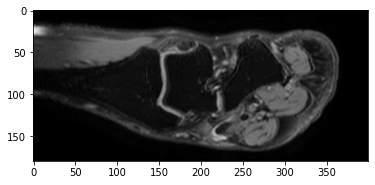

In [17]:
from matplotlib.pyplot import imshow
nda = sitk.GetArrayFromImage(image)
ax = imshow(nda[:,:, 200], cmap='gray')

In [18]:
type(image)

SimpleITK.SimpleITK.Image